In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from moment.data.dataloader import get_timeseries_dataloader
from moment.utils.anomaly_detection_metrics import get_anomaly_detection_metrics

from moment.utils.config import Config
from moment.utils.utils import parse_config
from moment.models.dghl import DGHL
from moment.models.timesnet import TimesNet
from moment.models.gpt4ts import GPT4TS
from moment.models.anomaly_nearest_neighbors import AnomalyNearestNeighbors
from moment.models.anomaly_transformer import AnomalyTransformer
from moment.data.dataloader import get_timeseries_dataloader

In [2]:
from moment.data.forecasting_datasets import ShortForecastingDataset, get_forecasting_datasets
from moment.data.classification_datasets import ClassificationDataset, get_classification_datasets

In [3]:
get_classification_datasets()

['/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/SemgHandGenderCh2/SemgHandGenderCh2_TEST.ts',
 '/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/GestureMidAirD2/GestureMidAirD2_TEST.ts',
 '/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/UWaveGestureLibraryAll/UWaveGestureLibraryAll_TEST.ts',
 '/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/SelfRegulationSCP1/SelfRegulationSCP1_TEST.ts',
 '/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/UWaveGestureLibraryX/UWaveGestureLibraryX_TEST.ts',
 '/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/GesturePebbleZ2/GesturePebbleZ2_TEST.ts',
 '/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/ECG5000/ECG5000_TEST.ts',
 '/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/OSULeaf/OSULeaf_TEST.ts',
 '/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/MedicalImages/MedicalIm

In [4]:
monash_datasets = get_forecasting_datasets(collection="monash")

In [5]:
[i for i in monash_datasets if 'us_births' in i]

['/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/forecasting/monash/us_births_dataset.tsf']

In [6]:
dataset = ShortForecastingDataset(
    full_file_path_and_name='/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/forecasting/monash/wind_4_seconds_dataset.tsf',
    data_split='train')

In [7]:
dataset

ShortForecastingDataset(dataset_name=wind_4_seconds_dataset,length_dataset=8668,seq_len=512,forecast_horizon=8,data_split=train,scale=True,task_name=short-horizon-forecasting,n_channels=1,train_ratio=0.6,val_ratio=0.1,test_ratio=0.3,

In [21]:
dataset = ClassificationDataset(
    full_file_path_and_name='/XXXX-14/project/public/XXXX-9/TimeseriesDatasets/classification/UCR/Ham/Ham_TEST.ts',
    data_split='test')

In [14]:
8*512/7305

0.5607118412046543

In [13]:
8668*512/7397147

0.5999632020291066

In [2]:
import time
from torch import optim
import wandb
from common import PATHS
from torch import nn
from tqdm import trange, tqdm

def train(args, model, train_dataloader):
        n_train_epochs = args.max_epoch
        
        # Training loop
        tr_loss = 0
        
        optimizer = optim.AdamW(model.parameters(), 
                                lr=args.init_lr,
                                weight_decay=args.weight_decay)

        criterion = nn.MSELoss() 

        logger = wandb.init(
            project="Time-series Foundation Model",
            dir=PATHS.WANDB_DIR)
        
        for epoch in trange(n_train_epochs):
            for batch in tqdm(train_dataloader, total=len(train_dataloader)):
                timeseries = batch.timeseries.float().to(args.device)
                input_mask = batch.input_mask.long().to(args.device).unsqueeze(1)

                model.train()
                # Training step
                outputs = model.detect_anomalies(x_enc=timeseries, 
                                input_mask=input_mask, mask=None,
                                anomaly_criterion=args.anomaly_criterion)
                
                loss = criterion(outputs.reconstruction, timeseries)

                if not np.isnan(float(loss)):
                    loss.backward()
                
                logger.log({
                     'step_loss_train': loss.item(),
                     'lr': optimizer.param_groups[0]['lr']})
                
                nn.utils.clip_grad_norm_(model.parameters(), args.max_norm)
                    
                optimizer.step()
                optimizer.zero_grad()
                
                tr_loss += loss.detach().cpu().numpy()

        logger.finish()

        return model

### GPT4TS

In [3]:
DEFAULT_CONFIG_PATH = "../../configs/default.yaml"
GPU_ID = 2

config = Config(config_file_path="../../configs/anomaly_detection/gpt4ts_train.yaml", 
                default_config_file_path=DEFAULT_CONFIG_PATH).parse()
config['device'] = GPU_ID if torch.cuda.is_available() else 'cpu'
args = parse_config(config)
args.task_name = 'long-horizon-forecasting'
args.forecast_horizon = 96

In [4]:
model = GPT4TS(args)
model.to(args.device)

Initializing pre-trained GPT-2.
Enabling gradient checkpointing.
GPT-2 = GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-5): 6 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


GPT4TS(
  (padding_patch_layer): ReplicationPad1d((0, 1))
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 16)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 16)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 16)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 16)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (gpt2): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_a

In [6]:
args.batch_size = args.train_batch_size
args.task_name = 'anomaly-detection'
train_dataloader = get_timeseries_dataloader(args=args)

In [7]:
for batch_x in train_dataloader:
    break

In [16]:
(model.enc_embedding.position_embedding(batch_x.timeseries.float().to(args.device)) + model.enc_embedding.value_embedding(batch_x.timeseries.float().to(args.device))).shape

torch.Size([64, 512, 16])

In [9]:
outputs = model.forecast(batch_x.timeseries.float().to(args.device))

x_enc torch.Size([64, 1, 512]) means torch.Size([64, 1, 1]) stdev torch.Size([64, 1, 1])
enc_out torch.Size([64, 512, 16])
enc_out torch.Size([64, 16, 512])
enc_out torch.Size([64, 512, 768])
dec_out torch.Size([64, 512, 768])
dec_out torch.Size([64, 512, 128])
dec_out torch.Size([64, 512, 1])


In [ ]:
model = train(args, model, train_dataloader)

In [1]:
from utils.ucr_anomaly_archive_subset import ucr_anomaly_archive_subset

script = ""
config = "../../configs/anomaly_detection/gpt4ts_train.yaml"
gpu_id = 1

for dataset_name in ucr_anomaly_archive_subset:
    script += f"python3 ../../scripts/baselines/gpt4ts_anomaly_detection.py --config {config} --gpu_id {gpu_id} --dataset_names {dataset_name}\n"

print(script)

python3 ../../scripts/baselines/gpt4ts_anomaly_detection.py --config ../../configs/anomaly_detection/gpt4ts_train.yaml --gpu_id 1 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/109_UCR_Anomaly_1sddb40_35000_52000_52620.out
python3 ../../scripts/baselines/gpt4ts_anomaly_detection.py --config ../../configs/anomaly_detection/gpt4ts_train.yaml --gpu_id 1 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/112_UCR_Anomaly_BIDMC1_2500_5400_5600.out
python3 ../../scripts/baselines/gpt4ts_anomaly_detection.py --config ../../configs/anomaly_detection/gpt4ts_train.yaml --gpu_id 1 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/115_UCR_Anomaly_CIMIS44AirTemperature3_4000_6520_6544.out
python3 ../../scripts/baselines/gpt4ts_anomaly_detection.py --config ../../configs/anomaly_detection/gpt4ts_train.yaml --gpu_id 1 --dataset_names /XX

### TimesNet

In [3]:
DEFAULT_CONFIG_PATH = "../../configs/default.yaml"
GPU_ID = 1

config = Config(config_file_path="../../configs/anomaly_detection/timesnet_train.yaml", 
                default_config_file_path=DEFAULT_CONFIG_PATH).parse()
config['device'] = GPU_ID if torch.cuda.is_available() else 'cpu'
args = parse_config(config)

In [4]:
model = TimesNet(args)
model.to(args.device)

TimesNet(
  (model): ModuleList(
    (0-2): 3 x TimesBlock(
      (conv): Sequential(
        (0): InceptionBlockV1(
          (kernels): ModuleList(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (3): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
            (4): Conv2d(16, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
            (5): Conv2d(16, 16, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
          )
        )
        (1): GELU(approximate='none')
        (2): InceptionBlockV1(
          (kernels): ModuleList(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
         

In [6]:
args.batch_size = args.train_batch_size
train_dataloader = get_timeseries_dataloader(args=args)

model = train(args, model, train_dataloader)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mononitog (timeseries-foundation-model). Use `wandb login --relogin` to force relogin


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See XXXX


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step_loss_train,█▇▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0001
step_loss_train,0.09687


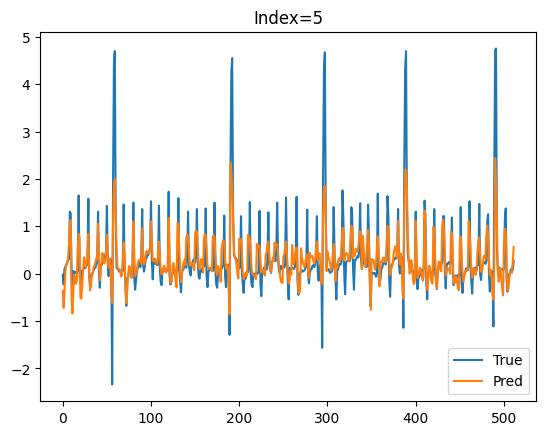

In [11]:
args.batch_size = args.train_batch_size
args.data_split = 'test'
dataloader = get_timeseries_dataloader(args=args)

idx = np.random.randint(0, len(dataloader))
datapoint = dataloader.dataset[idx]

Y = torch.from_numpy(datapoint.timeseries).unsqueeze(0).to(args.device).float()

outputs = model.reconstruct(Y, mask=None)
Y_hat = outputs.reconstruction

plt.title(f"Index={idx}")
plt.plot(Y.squeeze().detach().cpu().numpy(), label="True")
plt.plot(Y_hat.squeeze().detach().cpu().numpy(), label="Pred")
plt.legend()
plt.show()

In [5]:
from utils.ucr_anomaly_archive_subset import ucr_anomaly_archive_subset

script = ""
config = "../../configs/anomaly_detection/timesnet_train.yaml"
gpu_id = 1

for dataset_name in ucr_anomaly_archive_subset:
    script += f"python3 ../../scripts/baselines/timesnet_anomaly_detection.py --config {config} --gpu_id {gpu_id} --dataset_names {dataset_name}\n"

print(script)

python3 ../../scripts/baselines/timesnet_anomaly_detection.py --config ../../configs/anomaly_detection/timesnet_train.yaml --gpu_id 1 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/109_UCR_Anomaly_1sddb40_35000_52000_52620.out
python3 ../../scripts/baselines/timesnet_anomaly_detection.py --config ../../configs/anomaly_detection/timesnet_train.yaml --gpu_id 1 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/112_UCR_Anomaly_BIDMC1_2500_5400_5600.out
python3 ../../scripts/baselines/timesnet_anomaly_detection.py --config ../../configs/anomaly_detection/timesnet_train.yaml --gpu_id 1 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/115_UCR_Anomaly_CIMIS44AirTemperature3_4000_6520_6544.out
python3 ../../scripts/baselines/timesnet_anomaly_detection.py --config ../../configs/anomaly_detection/timesnet_train.yaml --gpu_id 1 --d

### DGHL

In [4]:
DEFAULT_CONFIG_PATH = "../../configs/default.yaml"
GPU_ID = 1

config = Config(config_file_path="../../configs/anomaly_detection/dghl_train.yaml", 
                default_config_file_path=DEFAULT_CONFIG_PATH).parse()
config['device'] = GPU_ID if torch.cuda.is_available() else 'cpu'
args = parse_config(config)

In [ ]:
model = DGHL(args)
model.to(args.device)

DGHL(
  (model): Generator(
    (layers): Sequential(
      (0): ConvTranspose1d(55, 256, kernel_size=(4,), stride=(1,), bias=False)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ConvTranspose1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
      (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): ConvTranspose1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
      (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
      (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
      (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
metadata = args.dataset_names.split('/')[-1].split('_')
data_id, data_name = metadata[0], metadata[3]

In [ ]:
args.batch_size = args.train_batch_size
train_dataloader = get_timeseries_dataloader(args=args)

model = train(args, model, train_dataloader)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mononitog (timeseries-foundation-model). Use `wandb login --relogin` to force relogin


100%|██████████| 10/10 [02:25<00:00, 14.54s/it]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See XXXX


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step_loss_train,█▂▂▁▂▂▂▁▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
lr,0.001
step_loss_train,1938.79053


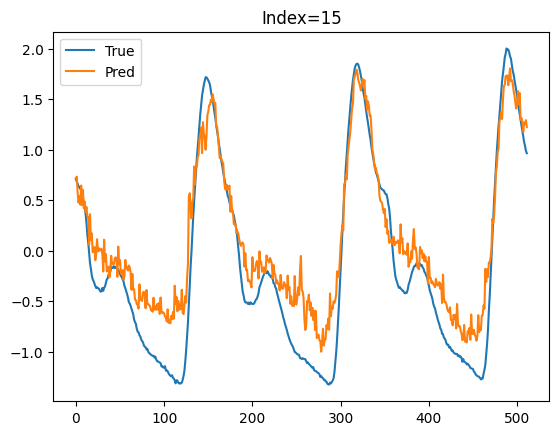

In [ ]:
args.batch_size = args.train_batch_size
args.data_split = 'test'
dataloader = get_timeseries_dataloader(args=args)

idx = np.random.randint(0, len(dataloader))
datapoint = dataloader.dataset[idx]

Y = torch.from_numpy(datapoint.timeseries).unsqueeze(0).to(args.device).float()
mask = torch.from_numpy(datapoint.input_mask).unsqueeze(0).to(args.device).unsqueeze(1).long()
# Remember to change the mask to (batch_size, n_chanels, n_timesteps)

Y, Y_hat, mask = model.reconstruct(Y, mask)

plt.title(f"Index={idx}")
plt.plot(Y.squeeze().detach().cpu().numpy(), label="True")
plt.plot(Y_hat.squeeze().detach().cpu().numpy(), label="Pred")
plt.legend()
plt.show()

In [ ]:
from utils.ucr_anomaly_archive_subset import ucr_anomaly_archive_subset

script = ""
config = "../../configs/anomaly_detection/dghl_train.yaml"
gpu_id = 4

for dataset_name in ucr_anomaly_archive_subset:
    script += f"python dghl_anomaly_detection.py --config {config} --gpu_id {gpu_id} --dataset_names {dataset_name}\n"

print(script)


python dghl_anomaly_detection.py --config ../../configs/anomaly_detection/dghl_train.yaml --gpu_id 4 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/109_UCR_Anomaly_1sddb40_35000_52000_52620.out
python dghl_anomaly_detection.py --config ../../configs/anomaly_detection/dghl_train.yaml --gpu_id 4 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/112_UCR_Anomaly_BIDMC1_2500_5400_5600.out
python dghl_anomaly_detection.py --config ../../configs/anomaly_detection/dghl_train.yaml --gpu_id 4 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/115_UCR_Anomaly_CIMIS44AirTemperature3_4000_6520_6544.out
python dghl_anomaly_detection.py --config ../../configs/anomaly_detection/dghl_train.yaml --gpu_id 4 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/117_UCR_Anomaly_CIMIS44AirTemp

### Anomaly Nearest Neighbor

In [ ]:
args.batch_size = args.train_batch_size
train_dataloader = get_timeseries_dataloader(args=args)
args.data_split = 'test'
test_dataloader = get_timeseries_dataloader(args=args)

args.n_neighbors = 5
model = AnomalyNearestNeighbors(args)

model.fit(train_dataloader=train_dataloader)

for batch in test_dataloader:
    Y = batch.timeseries
    mask = batch.input_mask
    outputs = model.forward(Y=Y, mask=mask)
    break

Y, Y_hat, mask = outputs

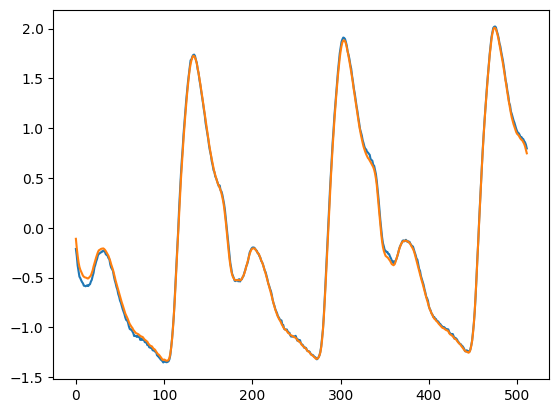

In [ ]:
plt.plot(Y.numpy().squeeze()[1, :])
plt.plot(Y_hat.numpy().squeeze()[1, :])

In [ ]:
datapoint = train_dataloader.dataset[0]

Y = torch.from_numpy(datapoint.timeseries).unsqueeze(0).to(args.device)
mask = torch.from_numpy(datapoint.input_mask).unsqueeze(0).to(args.device).unsqueeze(1)
# Remember to change the mask to (batch_size, n_chanels, n_timesteps)

In [ ]:
args.batch_size = 1

In [ ]:
outputs = model.reconstruct(Y=Y, mask=mask)

In [ ]:
Y_flatten, Y_hat_flatten, mask_flatten = outputs

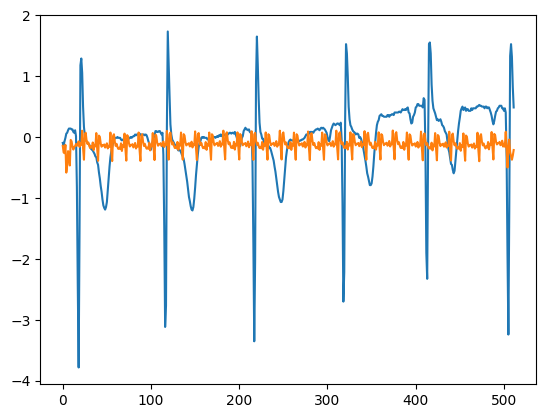

In [ ]:
plt.plot(Y_flatten.squeeze().detach().cpu().numpy())
plt.plot(Y_hat_flatten.squeeze().detach().cpu().numpy())

In [ ]:
from utils.ucr_anomaly_archive_subset import ucr_anomaly_archive_subset

script = ""
config = "../../configs/anomaly_detection/anomaly_transformer_train.yaml"
gpu_id = 5

for dataset_name in ucr_anomaly_archive_subset:
    script += f"python anomaly_transformer_anomaly_detection.py --config {config} --gpu_id {gpu_id} --dataset_names {dataset_name}\n"

print(script)


python anomaly_transformer_anomaly_detection.py --config ../../configs/anomaly_detection/anomaly_transformer_train.yaml --gpu_id 5 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/109_UCR_Anomaly_1sddb40_35000_52000_52620.out
python anomaly_transformer_anomaly_detection.py --config ../../configs/anomaly_detection/anomaly_transformer_train.yaml --gpu_id 5 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/112_UCR_Anomaly_BIDMC1_2500_5400_5600.out
python anomaly_transformer_anomaly_detection.py --config ../../configs/anomaly_detection/anomaly_transformer_train.yaml --gpu_id 5 --dataset_names /XXXX-14/project/public/XXXX-9/TimeseriesDatasets/anomaly_detection/TSB-UAD-Public/KDD21/115_UCR_Anomaly_CIMIS44AirTemperature3_4000_6520_6544.out
python anomaly_transformer_anomaly_detection.py --config ../../configs/anomaly_detection/anomaly_transformer_train.yaml --gpu_id 5 --dataset_names

### Anomaly Transformer

In [ ]:
DEFAULT_CONFIG_PATH = "../../configs/default.yaml"
GPU_ID = 0

config = Config(config_file_path="../../configs/anomaly_detection/anomaly_transformer_train.yaml", 
                default_config_file_path=DEFAULT_CONFIG_PATH).parse()
config['device'] = GPU_ID if torch.cuda.is_available() else 'cpu'
args = parse_config(config)

model = AnomalyTransformer(args).to(args.device)

model.to(args.device)
model.eval()

AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 512)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 512)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 512)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 512)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_project

In [ ]:
args.batch_size = args.train_batch_size
train_dataloader = get_timeseries_dataloader(args=args)

model = train(args, model, train_dataloader)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See XXXX


100%|██████████| 10/10 [18:55<00:00, 113.52s/it]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See XXXX


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step_loss_train,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0001
step_loss_train,0.00293


In [ ]:
args.data_split = 'test'
args.data_stride_len = args.seq_len
args.shuffle = False
test_dataloader = get_timeseries_dataloader(args=args)

preds = []
trues = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        Y = batch.timeseries.to(args.device).float()
        outputs = model.detect_anomalies(x_enc=Y)
        
        trues.append(Y.detach().cpu().numpy().squeeze())
        preds.append(outputs.reconstruction.detach().cpu().numpy().squeeze())

trues = np.concatenate(trues, axis=1).flatten()
preds = np.concatenate(preds, axis=1).flatten()
print(trues.shape, preds.shape, test_dataloader.dataset.length_timeseries)

100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

(2560,) (2560,) 2851


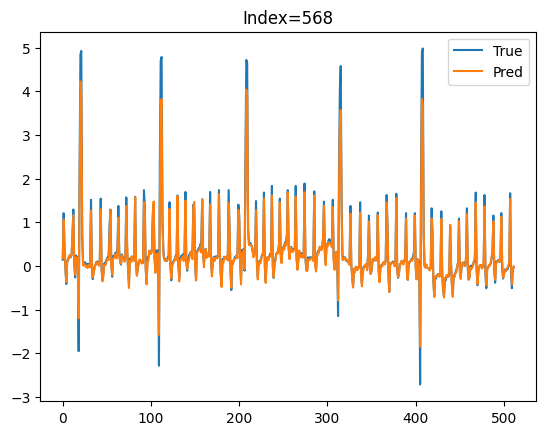

In [ ]:
idx = np.random.randint(0, len(trues) - args.seq_len)
plt.title(f"Index={idx}")
plt.plot(trues[idx:idx+args.seq_len], label='True')
plt.plot(preds[idx:idx+args.seq_len], label='Pred')
plt.legend()
plt.show()